# Decode block from video

In [3]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import glob
import re
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor, compute_smoothed_response_rate

%matplotlib notebook

In [4]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
    r"Y:\DRpilot_644866_20230208\processed",
    r"Y:\DRpilot_644866_20230209\processed",
    r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed",
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",
]



## loop through experiments, save all relevant info for each session

In [5]:
def custom_decoder(input_data,labels):
    
    output={}
    
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=5,shuffle=True)
    
    scaler.fit(input_data)
    X = scaler.transform(input_data)
    y = labels
    
    if len(np.unique(labels))>2:
        y_dec_func=np.full((len(y),len(np.unique(labels))), fill_value=np.nan)
    else:
        y_dec_func=np.full(len(y), fill_value=np.nan)
 
    if type(y[0])==bool:
        ypred=np.full(len(y), fill_value=False)
    elif type(y[0])==str:
        ypred=np.full(len(y), fill_value='       ')
    else:
        ypred=np.full(len(y), fill_value=np.nan)

    tidx_used=[]
    
    coefs=[]
    classes=[]
#     feature_names=[]
    intercept=[]
    params=[]

    for train,test in skf.split(X, y):
        clf=svm.LinearSVC(max_iter=5000)
        clf.fit(X[train],y[train])
        ypred[test] = clf.predict(X[test])
        y_dec_func[test] = clf.decision_function(X[test])
        tidx_used.append([test])
        coefs.append(clf.coef_)
        classes.append(clf.classes_)
#         feature_names.append(clf.feature_names_in_)
        intercept.append(clf.intercept_)
        params.append(clf.get_params())

    cr_dict=classification_report(y, ypred, output_dict=True)
    cr_df=pd.DataFrame.from_dict(cr_dict)

    output['cr']=cr_df
    output['pred_label']=ypred
    output['true_label']=y
    output['trial_sel_idx']=trial_sel
    output['trials_used']=tidx_used
    output['decision_function']=y_dec_func
    output['coefs']=coefs
    output['classes']=classes
#     output['feature_names']=feature_names
    output['intercept']=intercept
    output['params']=params
    
    return output


In [8]:
# def rand_forest_decoder(input_data,labels):
    ### make this and try it!!
#     output={}
    
#     scaler = StandardScaler()
#     skf = StratifiedKFold(n_splits=5,shuffle=True)
    
#     scaler.fit(sel_data.T)
#     X = scaler.transform(input_data)
#     y = labels
    
#     if len(np.unique(labels))>2:
#         y_dec_func=np.full((len(y),len(np.unique(labels))), fill_value=np.nan)
#     else:
#         y_dec_func=np.full(len(y), fill_value=np.nan)
 
#     if type(y[0])==bool:
#         ypred=np.full(len(y), fill_value=False)
#     elif type(y[0])==str:
#         ypred=np.full(len(y), fill_value='       ')
#     else:
#         ypred=np.full(len(y), fill_value=np.nan)

#     tidx_used=[]

#     for train,test in skf.split(X, y):
#         clf=svm.LinearSVC(max_iter=5000)
#         clf.fit(X[train],y[train])
#         ypred[test] = clf.predict(X[test])
#         y_dec_func[test] = clf.decision_function(X[test])
#         tidx_used.append([test])

#     cr_dict=classification_report(y, ypred, output_dict=True)
#     cr_df=pd.DataFrame.from_dict(cr_dict)

#     output['cr']=cr_df
#     output['pred_label']=ypred
#     output['true_label']=y
#     output['trial_sel_idx']=trial_sel
#     output['trials_used']=tidx_used
#     output['decision_function']=y_dec_func
    
#     return output

In [9]:
def match_run_speed(session):

    binsize=1
    speed_bins=np.arange(0,np.ceil(session.trials['avg_run_speed'].max()),binsize)

    visblock_run, edges = np.histogram(session.trials.query('trialstimRewarded=="vis1"')['avg_run_speed'],bins=speed_bins)
    audblock_run, edges = np.histogram(session.trials.query('trialstimRewarded=="sound1"')['avg_run_speed'],bins=speed_bins)

    choose_trials=[]

    for ib,bb in enumerate(edges[:-1]):

        n_chosen_trials = np.min([visblock_run[ib],audblock_run[ib]])

        visblock_trials = session.trials.query('trialstimRewarded=="vis1" and \
                                                avg_run_speed>=@speed_bins[@ib] and \
                                                avg_run_speed<@speed_bins[@ib+1]').index

        audblock_trials = session.trials.query('trialstimRewarded=="sound1" and \
                                                avg_run_speed>=@speed_bins[@ib] and \
                                                avg_run_speed<@speed_bins[@ib+1]').index

        choose_trials.append(np.random.choice(visblock_trials,n_chosen_trials,replace=False))
        choose_trials.append(np.random.choice(audblock_trials,n_chosen_trials,replace=False))


    choose_trials = np.sort(np.hstack(choose_trials))
    
    return choose_trials


In [10]:
def load_facemap_data(session,path,keep_n_SVDs=50):
    
    #load facemap data
    #load processed video data
    behav_path=glob.glob(os.path.join(path,"Behavior_*.npy"))[0]
    cam_frames_path = os.path.join(path,"camera_frames.pkl")

    behav_info=np.load(behav_path,allow_pickle=True)
    with open(cam_frames_path, 'rb') as filepath:
        cam_frames=pickle.load(filepath)

    session.cam_frames=cam_frames
    session.facemap_info={}
    session.facemap_info['motion']=behav_info.item()['motion'][1]
    session.facemap_info['motSVD']=behav_info.item()['motSVD'][1][:,:keep_n_SVDs]


    #calculate mean face motion, SVD in 1 sec prior to each trial
    # 1 sec before stimulus onset
    time_before=1
    time_after=0
    fps=60

    behav_SVD_by_trial = np.zeros(((time_before+time_after)*fps,keep_n_SVDs,len(session.trials)))
    behav_motion_by_trial = np.zeros(((time_before+time_after)*fps,len(session.trials)))

    behav_SVD_by_trial[:]=np.nan
    behav_motion_by_trial[:]=np.nan

    for tt,stimStartTime in enumerate(session.trials['stimStartTime']):
        if len(np.where(session.cam_frames['behavior']>=stimStartTime)[0])>0:
            stim_start_frame=np.where(session.cam_frames['behavior']>=stimStartTime)[0][0]
            trial_start_frame=stim_start_frame-time_before*fps
            trial_end_frame=stim_start_frame+time_after*fps

            behav_SVD_by_trial[:,:,tt] = session.facemap_info['motSVD'][trial_start_frame:trial_end_frame,:keep_n_SVDs]    
            behav_motion_by_trial[:,tt] = session.facemap_info['motion'][trial_start_frame:trial_end_frame]

    mean_trial_behav_SVD = np.nanmean(behav_SVD_by_trial,axis=0)
    mean_trial_behav_motion = np.nanmean(behav_motion_by_trial,axis=0)

    #add to session trial table
    session.trials['behav_motion'] = mean_trial_behav_motion
    for xx in range(0,keep_n_SVDs):
        session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]

    return session, mean_trial_behav_SVD

In [24]:
trnum='all'
f_num=500
f_min=500
n_repeats=1
binsize=0.2
time_bins=np.arange(-0.2,0,binsize)
balance_labels=0
keep_n_SVDs=500

# svc_results={}

for sel_session, path in enumerate(main_path[:]):
    
    svc_results={}
    
    session=[]
    session=Session(path=path) 
#     session.assign_unit_areas()
#     session=compute_smoothed_response_rate(session)

    session,mean_trial_behav_SVD = load_facemap_data(session,path,keep_n_SVDs)
    print('facemap data loaded')
    
    #mean_trial_behav_SVD[feature, trial]
    
    #try using running alone, motion alone, SVDs, or all of them
    
    predict=['block_ids']

    #save metadata about this session & decoder params
    svc_results['metadata']=session.metadata
    svc_results['trial_numbers']=trnum
    svc_results['feature_numbers']=f_num
    svc_results['min_n_features']=f_min
    svc_results['n_repeats']=n_repeats
    svc_results['time_bins']=time_bins
    svc_results['balance_labels']=balance_labels
    
    #loop through different labels to predict
    for p in predict:
        svc_results[p]={}

        if p=='block_ids':
            #exclude any trials that had opto stimulation
            if 'trialOptoVoltage' in session.trials.columns:
                trial_sel = session.trials.query('trialOptoVoltage.isnull()').index
            else:
                trial_sel = session.trials.index
                
            # or, use block IDs
            pred_var = session.trials['trialstimRewarded'][trial_sel].values

        SVD=mean_trial_behav_SVD[:,trial_sel]
        
        feature_sel = np.arange(0,SVD.shape[0])
        
        aa=0
        
        svc_results[p][aa]={}
        svc_results[p][aa]['n_features']=len(feature_sel)

        #loop through time bins
        for tt,t_start in enumerate(time_bins):
            
            svc_results[p][aa][tt]={}

            #loop through repeats
            for nn in range(0,n_repeats):

                #temporary hack - if combining all areas, use all units
#                     if u_num=='all':
                if aa=='all':
                    feature_subset = feature_sel #np.random.choice(unit_sel,len(unit_sel),replace=False)
                else:
                    feature_subset = np.random.choice(feature_sel,f_num,replace=False)

                #option to balance number of labels for training
                if balance_labels:
                    subset_ind=[]
                    conds = np.unique(pred_var)
                    cond_count=[]

                    if trnum=='all':
                        for cc in conds:
                            cond_count.append(np.sum(pred_var==cc))
                        use_trnum=np.min(cond_count)
                    else:
                        use_trnum = trnum

                    for cc in conds:
                        cond_inds=np.where(pred_var==cc)[0]
                        if len(cond_inds)<use_trnum:
                            use_trnum=len(cond_inds)
                        subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
                    subset_ind=np.sort(np.hstack(subset_ind))

#                         trial_sel=trial_sel[subset_ind]
#                         pred_var=pred_var[subset_ind]
                else:
                    subset_ind=np.arange(0,len(trial_sel))


                sel_data = SVD[feature_subset,subset_ind[:,np.newaxis]]
                
                if np.sum(np.isnan(sel_data))>0:
                    continue
                
                svc_results[p][aa][tt][nn]=custom_decoder(
                    input_data=sel_data,
                    labels=pred_var[subset_ind].flatten())

                svc_results[p][aa][tt][nn]['shuffle']=custom_decoder(
                    input_data=sel_data,
                    labels=np.random.choice(pred_var[subset_ind],len(pred_var),replace=False).flatten())

                svc_results[p][aa][tt][nn]['trial_sel_idx']=trial_sel
                svc_results[p][aa][tt][nn]['feature_sel_idx']=feature_subset

    print(path+' done')
    
            
    savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\use_video\use_500_SVD_features_200ms'

    with open(os.path.join(savepath,session.metadata['mouseID']+'_'+str(session.metadata['ephys_session_num'])+
                           'decoder_results_500SVD_features_200ms.pkl'), 'wb') as handle:
        pickle.dump(svc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)        

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:39: RuntimeWarning: Mean of empty slice
  mean_trial_behav_SVD = np.nanmean(behav_SVD_by_trial,axis=0)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:40: RuntimeWarning: Mean of empty slice
  mean_trial_behav_motion = np.nanmean(behav_motion_by_trial,axis=0)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

facemap data loaded
\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
Y:\DRpilot_644866_20230208\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
Y:\DRpilot_644866_20230209\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
Y:\DRpilot_644866_20230210\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
Y:\DRpilot_644867_20230220\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:39: RuntimeWarning: Mean of empty slice
  mean_trial_behav_SVD = np.nanmean(behav_SVD_by_trial,axis=0)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:40: RuntimeWarning: Mean of empty slice
  mean_trial_behav_motion = np.nanmean(behav_motion_by_trial,axis=0)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

facemap data loaded
Y:\DRpilot_644867_20230221\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
Y:\DRpilot_644867_20230222\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:39: RuntimeWarning: Mean of empty slice
  mean_trial_behav_SVD = np.nanmean(behav_SVD_by_trial,axis=0)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:40: RuntimeWarning: Mean of empty slice
  mean_trial_behav_motion = np.nanmean(behav_motion_by_trial,axis=0)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

facemap data loaded
Y:\DRpilot_644867_20230223\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:39: RuntimeWarning: Mean of empty slice
  mean_trial_behav_SVD = np.nanmean(behav_SVD_by_trial,axis=0)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:40: RuntimeWarning: Mean of empty slice
  mean_trial_behav_motion = np.nanmean(behav_motion_by_trial,axis=0)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

facemap data loaded
Y:\DRpilot_649943_20230213\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
Y:\DRpilot_649943_20230214\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
Y:\DRpilot_649943_20230215\processed done


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session.trials['behav_SVD_'+str(xx)] = mean_trial_behav_SVD[xx,:]
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3453097278.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

facemap data loaded
Y:\DRpilot_649943_20230216\processed done


In [ ]:
# subset_ind[:,np.newaxis]
np.sum(np.isnan(SVD))>0

In [ ]:
SVD.shape
pred_var.shape

In [ ]:
trial_sel[subset_ind].shape

## balance for running

In [ ]:
# balance for running
trnum='all'
u_num='all'
u_min=20
n_repeats=20
binsize=0.2
time_bins=np.arange(-0.2,0.6,binsize)
balance_labels=0
balance_running=0

# svc_results={}

for sel_session, path in enumerate(main_path):
    
    svc_results={}
    
    session=[]
    session=Session(path=path) 
    session.assign_unit_areas()
    session=compute_smoothed_response_rate(session)
    
    # loop through sessions and make unit xarrays
    time_before_flash = 0.25
    trial_duration = 1.0
    bin_size = 0.001

    # Make tensor (3-D matrix [units,time,trials])
    trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                                  session.trials,time_before_flash, trial_duration, 
                                                  bin_size)
    # make xarray
    session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                               coords={
                                   "unit_id": session.good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "trials": session.trials.index.values
                                   })
    
    #shorten the area names to better lump together units
    #get rid of layers and/or sub-areas with dashes
    area_short = []
    for area in session.good_units['area']:
        if area=='N/A':
            short='N/A'
        elif area[:2]=='CA':
            short=area
        else:
            dig_ind=re.search(r"\d", area)
            dash_ind=re.search(r"-", area)
            if dig_ind!=None:
                short=area[:dig_ind.start()]
            elif dash_ind!=None:
                short=area[:dash_ind.start()]
            else:
                short=area
        area_short.append(short)
    session.good_units['area_short']=area_short
    area_counts=session.good_units['area_short'].value_counts()

    #exclude any trials that had opto stimulation
    if 'trialOptoVoltage' in session.trials.columns:
        trial_sel = session.trials.query('trialOptoVoltage.isnull()').index
    else:
        trial_sel = session.trials.index
            
    if balance_running:
        run_trial_sel = match_run_speed(session)
        
    predict=['stim_ids','block_ids','trial_response']

    # grab the stimulus ids
    stim_ids = session.trials['trialStimID'][trial_sel].values
    # or, use block IDs
    block_ids = session.trials['trialstimRewarded'][trial_sel].values
    #or, use whether mouse responded
    trial_response = session.trials['trial_response'][trial_sel].values
    
    #save metadata about this session & decoder params
    svc_results['metadata']=session.metadata
    svc_results['trial_numbers']=trnum
    svc_results['unit_numbers']=u_num
    svc_results['min_n_units']=u_min
    svc_results['n_repeats']=n_repeats
    svc_results['time_bins']=time_bins
    svc_results['balance_labels']=balance_labels
    
    #loop through different labels to predict
    for p in predict:
        svc_results[p]={}
    
        #choose what variable to predict
        if p=='stim_ids':
            pred_var = stim_ids
        elif p=='block_ids':
            pred_var = block_ids
        elif p=='trial_response':
            pred_var = trial_response
            
        if balance_running:
            if p=='stim_ids':
                run_pred_var = session.trials['trialStimID'][run_trial_sel].values
            elif p=='block_ids':
                run_pred_var = session.trials['trialstimRewarded'][run_trial_sel].values
            elif p=='trial_response':
                run_pred_var = session.trials['trial_response'][run_trial_sel].values

        area_sel = area_counts[area_counts>=u_min].index
        # area_sel = ['all']
        
        #loop through areas
        for aa in area_sel:
            if aa=='all':
                unit_sel = session.good_units.index.values
            else:
                unit_sel = session.good_units.query('area_short==@aa').index.values
            svc_results[p][aa]={}
            svc_results[p][aa]['n_units']=len(unit_sel)
            
            #loop through time bins
            for tt,t_start in enumerate(time_bins[:-1]):
                svc_results[p][aa][tt]={}
                
                #loop through repeats
                for nn in range(0,n_repeats):
                    
                    if u_num=='all':
                        unit_subset = np.random.choice(unit_sel,len(unit_sel),replace=False)
                    else:
                        unit_subset = np.random.choice(unit_sel,u_num,replace=False)
                    
#                     #option to balance number of labels for training
####### need to fix this! potnetially sub-selecting pred_var too much!
#                     if balance_labels:
#                         subset_ind=[]
#                         conds = np.unique(pred_var)
#                         cond_count=[]

#                         if trnum=='all':
#                             for cc in conds:
#                                 cond_count.append(np.sum(pred_var==cc))
#                             use_trnum=np.min(cond_count)
#                         else:
#                             use_trnum = trnum

#                         for cc in conds:
#                             cond_inds=np.where(pred_var==cc)[0]
#                             if len(cond_inds)<use_trnum:
#                                 use_trnum=len(cond_inds)
#                             subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
#                         subset_ind=np.sort(np.hstack(subset_ind))

#                         trial_sel=trial_sel[subset_ind]
#                         pred_var=pred_var[subset_ind]


                    sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                                    trials=trial_sel,
                                                    unit_id=unit_subset).mean(dim='time').values

                    svc_results[p][aa][tt][nn]=custom_decoder(
                        input_data=sel_data.T,
                        labels=pred_var.flatten())
                    
                    svc_results[p][aa][tt][nn]['trial_sel_idx']=trial_sel
                    
                    if balance_running:
                        
                        run_sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                                    trials=run_trial_sel,
                                                    unit_id=unit_subset).mean(dim='time').values
                        
                        svc_results[p][aa][tt][nn]['balance_running']=custom_decoder(
                            input_data=run_sel_data.T,
                            labels=run_pred_var.flatten())
                        
                        svc_results[p][aa][tt][nn]['balance_running']['trial_sel_idx']=run_trial_sel

                        
            print(aa+' done')
            
    print(path+' done')
    
            
    savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\by_session\balance_running'

    with open(os.path.join(savepath,session.metadata['mouseID']+'_'+str(session.metadata['ephys_session_num'])+
                           'decoder_results_200ms_balance_running.pkl'), 'wb') as handle:
        pickle.dump(svc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)        

## load & plot

In [25]:
loadpath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\use_video\use_500_SVD_features_200ms'

svc_results={}
decoder_results=os.listdir(loadpath)

for ii,ff in enumerate(decoder_results):
    with open(os.path.join(loadpath,ff),'rb') as handle:
        svc_results[ii]=pickle.load(handle)
    print(ff)

626791_1decoder_results_500SVD_features_200ms.pkl
626791_2decoder_results_500SVD_features_200ms.pkl
626791_3decoder_results_500SVD_features_200ms.pkl
636766_1decoder_results_500SVD_features_200ms.pkl
636766_2decoder_results_500SVD_features_200ms.pkl
636766_3decoder_results_500SVD_features_200ms.pkl
636766_4decoder_results_500SVD_features_200ms.pkl
644864_1decoder_results_500SVD_features_200ms.pkl
644864_2decoder_results_500SVD_features_200ms.pkl
644864_3decoder_results_500SVD_features_200ms.pkl
644864_4decoder_results_500SVD_features_200ms.pkl
644866_2decoder_results_500SVD_features_200ms.pkl
644866_3decoder_results_500SVD_features_200ms.pkl
644866_4decoder_results_500SVD_features_200ms.pkl
644867_1decoder_results_500SVD_features_200ms.pkl
644867_2decoder_results_500SVD_features_200ms.pkl
644867_3decoder_results_500SVD_features_200ms.pkl
644867_4decoder_results_500SVD_features_200ms.pkl
649943_1decoder_results_500SVD_features_200ms.pkl
649943_2decoder_results_500SVD_features_200ms.pkl


In [26]:
# all unique areas in results
all_areas=[]
for sel_session in range(0,len(svc_results)):
    all_areas.append(list(svc_results[sel_session]['block_ids'].keys()))
    
all_areas=np.unique(np.hstack(all_areas))

In [27]:
# all_areas
svc_results[0]['n_repeats']

1

In [30]:
# make into more plottable format

####change this to deal with multiple #s of trials and average over re-runs of the SVC

plot_results={}
plot_shuffle_results={}

timepoints=svc_results[0]['time_bins']
n_repeats=svc_results[0]['n_repeats']

label_list=['vis1','vis2','sound1','sound2','True','False']
# label_list=['vis1','sound1','True','False']

# predict=['stim_ids','block_ids','trial_response']
predict=['block_ids']

# areas=['VISp','AUD','LG','MG','MOs','MRN','CP','MOp']
# areas=all_areas
areas=[0]

for sel_session in range(0,len(svc_results)):
    plot_results[sel_session]={}
    plot_shuffle_results[sel_session]={}
    for aa in areas:
        plot_results[sel_session][aa]={}
        plot_shuffle_results[sel_session][aa]={}
        for p in predict:
            plot_results[sel_session][aa][p]={}
            plot_shuffle_results[sel_session][aa][p]={}
            for ll in label_list:
                plot_results[sel_session][aa][p][ll]=np.zeros((len(timepoints),n_repeats))
                plot_results[sel_session][aa][p][ll][:]=np.nan
                
                plot_shuffle_results[sel_session][aa][p][ll]=np.zeros((len(timepoints),n_repeats))
                plot_shuffle_results[sel_session][aa][p][ll][:]=np.nan

    
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

decoder_acc_session_mean = {}
decoder_acc_session_shuffle_mean = {}
for aa in areas:
    decoder_acc_session_mean[aa]={}
    decoder_acc_session_shuffle_mean[aa]={}
    for p in predict:
        decoder_acc_session_mean[aa][p]={}
        decoder_acc_session_shuffle_mean[aa][p]={}
        for ll in label_list:
            
            decoder_acc_session_mean[aa][p][ll]=np.zeros((len(timepoints),
                                                           len(main_path)))
            decoder_acc_session_mean[aa][p][ll][:]=np.nan
            
            decoder_acc_session_shuffle_mean[aa][p][ll]=np.zeros((len(timepoints),
                                                           len(main_path)))
            decoder_acc_session_shuffle_mean[aa][p][ll][:]=np.nan
        

for sel_session in range(0,len(svc_results)):
    for p in predict:
        for aa in areas: 
            if aa in svc_results[sel_session][p].keys():
                for tt,tp in enumerate(timepoints):
                    for nn in range(0,n_repeats):
                        for ll in label_list:
                            if len(svc_results[sel_session][p][aa])>0:
                                if len(svc_results[sel_session][p][aa][tt])>0:
                                    if ll in svc_results[sel_session][p][aa][tt][nn]['cr'].keys():
                                        temp_perf=np.nanmean(svc_results[sel_session][p]
                                                          [aa][tt][nn]['cr'][ll]
                                                          [['precision','recall']].values)
                                        plot_results[sel_session][aa][p][ll][tt,nn]=temp_perf
                                        
                                        temp_shuff_perf=np.nanmean(svc_results[sel_session][p]
                                                          [aa][tt][nn]['shuffle']['cr'][ll]
                                                          [['precision','recall']].values)
                                        plot_shuffle_results[sel_session][aa][p][ll][tt,nn]=temp_shuff_perf

                    for ll in label_list:
                        if len(svc_results[sel_session][p][aa])>0:                    
                            decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
                            decoder_acc_session_mean[aa][p][ll][tt,sel_session] = decoder_acc_mean
    
                            decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
                            decoder_acc_session_shuffle_mean[aa][p][ll][tt,sel_session] = decoder_acc_shuffle_mean
# plot_results[area][label/stimulus][timepoint_idx][ntrials_idx,nunits_idx,n_repeats]

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3794364185.py:83: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3794364185.py:86: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3794364185.py:83: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3794364185.py:86: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\3794364185.py:83: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\T

In [31]:
svc_results[sel_session][p][aa][tt][nn]['cr'].keys()
# ll

Index(['sound1', 'vis1', 'accuracy', 'macro avg', 'weighted avg'], dtype='object')

In [32]:
# plot_results[0][0]['block_ids']['vis1'][tt,nn]
timepoints

array([-0.2])

In [34]:
decoder_acc_session_mean[0]['block_ids']

{'vis1': array([[0.80388244, 0.8005305 , 0.88905442, 0.84320193, 0.84553634,
         0.83992165, 0.82264957, 0.82904211, 0.84887879, 0.90120773,
                nan, 0.88383838, 0.88850936, 0.88059701, 0.92668143,
                nan, 0.89754428,        nan,        nan, 0.93967617,
         0.80220857, 0.82798027]]),
 'vis2': array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan]]),
 'sound1': array([[0.76222635, 0.79650897, 0.88862076, 0.83584656, 0.85504039,
         0.85495068, 0.81121495, 0.82711443, 0.84946253, 0.89382548,
                nan, 0.88471654, 0.88515066, 0.87692308, 0.91948184,
                nan, 0.89074733,        nan,        nan, 0.941868  ,
         0.8029304 , 0.83117169]]),
 'sound2': array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan]]),
 'True': array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [35]:
np.nanmean(np.vstack([decoder_acc_session_mean[0]['block_ids']['vis1'],
                      decoder_acc_session_mean[0]['block_ids']['sound1']]),axis=0)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\374608817.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(np.vstack([decoder_acc_session_mean[0]['block_ids']['vis1'],


array([0.78305439, 0.79851973, 0.88883759, 0.83952425, 0.85028836,
       0.84743616, 0.81693226, 0.82807827, 0.84917066, 0.8975166 ,
              nan, 0.88427746, 0.88683001, 0.87876005, 0.92308164,
              nan, 0.8941458 ,        nan,        nan, 0.94077208,
       0.80256948, 0.82957598])

In [36]:
np.nanmean(np.vstack([decoder_acc_session_shuffle_mean[0]['block_ids']['vis1'],
                      decoder_acc_session_shuffle_mean[0]['block_ids']['sound1']]),axis=0)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\1232815286.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(np.vstack([decoder_acc_session_shuffle_mean[0]['block_ids']['vis1'],


array([0.49598344, 0.46983548, 0.49603211, 0.47660446, 0.44530797,
       0.51577338, 0.47775386, 0.50842033, 0.51406463, 0.51340272,
              nan, 0.51415319, 0.53065791, 0.53794162, 0.50493061,
              nan, 0.51423996,        nan,        nan, 0.52025317,
       0.497308  , 0.50573293])

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\1068730131.py:1: RuntimeWarning: Mean of empty slice
  face_decoder_perf = np.nanmean(np.vstack([decoder_acc_session_mean[0]['block_ids']['vis1'],
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_24872\1068730131.py:3: RuntimeWarning: Mean of empty slice
  face_decoder_shuffle_perf = np.nanmean(np.vstack([decoder_acc_session_shuffle_mean[0]['block_ids']['vis1'],


<IPython.core.display.Javascript object>


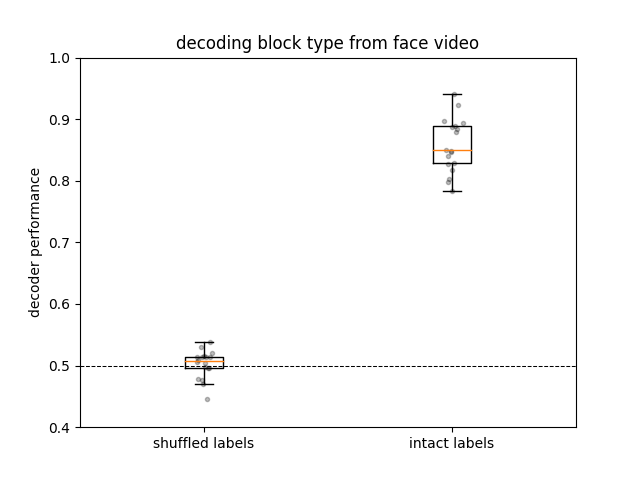

Text(0.5, 1.0, 'decoding block type from face video')

In [37]:
face_decoder_perf = np.nanmean(np.vstack([decoder_acc_session_mean[0]['block_ids']['vis1'],
                              decoder_acc_session_mean[0]['block_ids']['sound1']]),axis=0)
face_decoder_shuffle_perf = np.nanmean(np.vstack([decoder_acc_session_shuffle_mean[0]['block_ids']['vis1'],
                                      decoder_acc_session_shuffle_mean[0]['block_ids']['sound1']]),axis=0)

face_decoder_perf=face_decoder_perf[~np.isnan(face_decoder_perf)]
face_decoder_shuffle_perf=face_decoder_shuffle_perf[~np.isnan(face_decoder_shuffle_perf)]

fig,ax=plt.subplots(1,1)
ax.axhline(0.5,color='k',linestyle='--',linewidth=0.75)
ax.boxplot([face_decoder_shuffle_perf,face_decoder_perf],showfliers=False)

x = np.random.normal(1, 0.02, size=len(face_decoder_shuffle_perf))
ax.plot(x,face_decoder_shuffle_perf,'k.',alpha=0.25)

x = np.random.normal(2, 0.02, size=len(face_decoder_shuffle_perf))
ax.plot(x,face_decoder_perf,'k.',alpha=0.25)

ax.set_ylim([0.4,1])
ax.set_ylabel('decoder performance')
ax.set_xticks([1,2])
ax.set_xticklabels(['shuffled labels','intact labels'])
ax.set_title('decoding block type from face video')


In [ ]:
svc_results[sel_session][p][aa][tt][nn]['balance_running']['cr']

In [ ]:
svc_results[20]['block_ids'][0][0][0]['shuffle']

In [ ]:
fig,ax=plt.subplots(1,1)
ax.hist(svc_results[20]['block_ids'][0][0][0]['decision_function'],bins=50)

In [ ]:
predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
ax.axhline(0.25,color='k',linestyle='--',linewidth=1)

# ax.plot(time_bins[1:],decoder_acc_session_mean['VISp'][predict_var][sel_stim],'k',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['AUDp'][predict_var][sel_stim],'m',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['MOs'][predict_var][sel_stim],'b',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['MRN'][predict_var][sel_stim],'r',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['CP'][predict_var][sel_stim],'g',linewidth=0.75,alpha=0.5)


visp_line=ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['all'][predict_var][sel_stim],axis=1)
        ,'k.-',linewidth=2)

visp_line_balance_running=ax.plot(time_bins[1:],
                                  np.nanmean(decoder_acc_session_shuffle_mean['all'][predict_var][sel_stim],axis=1)
                                  ,'k^--',linewidth=1.5)

# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['AUDp'][predict_var][sel_stim],axis=1)
#         ,'m.-',linewidth=2)
# mos_line=ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
#         ,'b.-',linewidth=2)

# mos_line_balance_running=ax.plot(time_bins[1:],
#                                   np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)
#                                   ,'b^--',linewidth=1.5)

# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['MRN'][predict_var][sel_stim],axis=1)
#         ,'r.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['CP'][predict_var][sel_stim],axis=1)
#         ,'g.-',linewidth=2)


ax.set_ylim([0.4,1.0])
ax.set_xlabel('time relative to stim onset (s)')
ax.set_ylabel('block decoding accuracy')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-shuffle','MOs','MOs-shuffle'])

In [ ]:
predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
ax.axhline(0.5,color='k',linestyle='--',linewidth=1)


visp_line=ax.errorbar(time_bins[1:],np.nanmean(decoder_acc_session_mean['VISp'][predict_var][sel_stim],axis=1),
                      yerr=np.nanstd(decoder_acc_session_mean['VISp'][predict_var][sel_stim],axis=1)/
                      np.sqrt(decoder_acc_session_mean['VISp'][predict_var][sel_stim].shape[1]),
                      fmt='k.-',linewidth=2, capsize=2)


visp_line_balance_running=ax.errorbar(time_bins[1:],
                                    np.nanmean(decoder_acc_session_shuffle_mean['VISp'][predict_var][sel_stim],axis=1),
                                    yerr=np.nanstd(decoder_acc_session_shuffle_mean['VISp'][predict_var][sel_stim],axis=1)/
                                    np.sqrt(decoder_acc_session_shuffle_mean['VISp'][predict_var][sel_stim].shape[1]),
                                    fmt='k^--',linewidth=1.5, capsize=2)


# mos_line=ax.errorbar(time_bins[1:],np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1),
#                      yerr=np.nanstd(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)/
#                      np.sqrt(decoder_acc_session_mean['MOs'][predict_var][sel_stim].shape[1]),
#                      fmt='b.-',linewidth=2, capsize=2)


# mos_line_balance_running=ax.errorbar(time_bins[1:],
#                                     np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1),
#                                     yerr=np.nanstd(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)/
#                                     np.sqrt(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim].shape[1]),
#                                     fmt='b^--',linewidth=1.5, capsize=2)



ax.set_ylim([0.4,1.0])
ax.set_xlabel('time relative to stim onset (s)')
ax.set_ylabel('block decoding accuracy')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
          ['VISp','VISp-shuffle','MOs','MOs-shuffle'])

In [ ]:
all_areas

In [ ]:
#shaded error bars - MOs only

predict_var='block_ids'
sel_stim='vis1'

sel_area='VPM'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
# ax.axhline(0.25,color='k',linestyle='--',linewidth=1)


y1=np.nanmean(decoder_acc_session_mean[sel_area][predict_var][sel_stim],axis=1)
err1=(np.nanstd(decoder_acc_session_mean[sel_area][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_mean[sel_area][predict_var][sel_stim][0,:]))))
l1=ax.plot(time_bins[1:], y1,'k',linestyle='-')
plt.fill_between(time_bins[1:], y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


y2=np.nanmean(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim],axis=1)
err2=(np.nanstd(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim][0,:]))))
l2=ax.plot(time_bins[1:], y2,'k',linestyle='--')
plt.fill_between(time_bins[1:], y2-err1, y2+err1,
    alpha=0.2, edgecolor=None, facecolor='k')



ax.set_ylim([0.44,1.0])
# ax.set_ylim([0.15,1.0])
ax.set_xlabel('time relative to stim onset (s)')
ax.set_ylabel('stimulus decoding accuracy')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([l1[0],l2[0]],[sel_area,sel_area+'-shuffle'])
fig.tight_layout()

In [ ]:
#multiple areas - sharded error bars

#shaded error bars - MOs only

predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
# ax.axhline(0.25,color='k',linestyle='--',linewidth=1)


y1=np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
err1=(np.nanstd(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:]))))
l1=ax.plot(time_bins[1:], y1,'k',linestyle='-')
plt.fill_between(time_bins[1:], y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


y2=np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)
err2=(np.nanstd(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim][0,:]))))
l2=ax.plot(time_bins[1:], y2,'k',linestyle='--')
plt.fill_between(time_bins[1:], y2-err1, y2+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


ax.set_ylim([0.44,1.0])
# ax.set_ylim([0.15,1.0])
ax.set_xlabel('time relative to stim onset (s)')
ax.set_ylabel('stimulus decoding accuracy')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([l1[0],l2[0]],['MOs','MOs-shuffle'])
fig.tight_layout()



In [ ]:
# os.listdir(loadpath)
# decoder_acc_session_mean['VISp'][predict_var][sel_stim].shape[1]
np.sum(~np.isnan(decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:]))

In [ ]:
# with open(os.path.join(loadpath,decoder_results[0]),'rb') as handle:
#     X=pickle.load(handle)        
# X


In [ ]:
# X['metadata']